In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

Давайте представим, что у нас с вами есть сервис, который работает по подписке (онлайн игра, стриминговый сервис, например). Один из важных факторов успешности бизнеса в таком случае - это удержание пользователей, нам надо придумать, как заинтересовать пользователя в продлении подпсики. Возникла идея дать скидку в $1\%$ на продление подписки. Чтобы оценить эфект от этой идеи мы как-то разбили пользователей, которые купили подписку за период теста, на две группы и одним дали скидку на продление, а другим нет.

In [2]:
df1 = pd.read_csv('subscribers_1.csv', sep=',')
print(df1.shape)
df1.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,1
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,1
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `rn` - порядковый номер покупки подписки за период.  
* `last_duration_days` - длительность предыдущей подписки.
* `new_duration_days` - длительность текущей подписки.
* `is_same` - менялась ли длительность подписки.
* `group` - группа теста, в которую попал пользователь. 1 - тест, 0 - контроль.

В описании датасета сказано, что за период теста пользователи покупали подписку, и затем некоторым была предложена скидка на продление.

Входят ли только покупки или только продления в датасет?


In [4]:
df1['new_duration_days'].value_counts(dropna=False)

,count
new_duration_days,
30,24934
90,856
180,145


In [5]:
df1['new_duration_days'].isna().sum()

np.int64(0)

 В реальности не все пользователи продлевают подписку, но в колонке "new_duration_days" ненулевые данные для всех пользователей.

 Следовательно, датасет содержит данные только для пользователей, продлявших подписку за период тестирования. Неясным остается то, (и лежит за пределами датасета), не уронила ли скидка количество желающих продлевать подписку в принципе.

 Например, доля желающих продлить подписку могла бы существенно снизиться, хотя структура желающих могла бы улучшиться (более долгие подписки), и из AB теста был бы сделан неверный вывод, что скидка 1% имеет положительное влияние.

Проверим, что данные относятся к одному сервису

In [6]:
df1['service_id'].value_counts(dropna=False)

,count
service_id,
929,25935


Да, это так

__а)__ Рассчитайте результаты АБ-теста. Найдите разницу между новой и старой длительностями подписки. Постройте для этой разницы гистограмму. Подумайте и дайте себе ответ на следующие вопросы:

- Можно ли воспользоваться предпосылкой о нормальности распределения приростов и проверить гипотезу тестом Уэлча?
- Переменная, для которой мы проводим тест имеет дискретное распределение. Можно ли здесь использовать тест Манна-Уитни? Даст ли это коректный результат?
- Будет ли корректно использовать для проверки гипотезы ЦПТ и тест о равенстве средних, основанный на ней?

In [7]:
df1['subscribe_difference'] = df1['new_duration_days'] - df1['last_duration_days']

In [8]:
test_subscribe = df1[df1['group']==1]['subscribe_difference']
control_subscribe = df1[df1['group']==0]['subscribe_difference']

In [9]:
test_subscribe.value_counts()

,count
subscribe_difference,
0.0,12610
60.0,368
-60.0,94
150.0,62
90.0,8
-90.0,1
-150.0,1


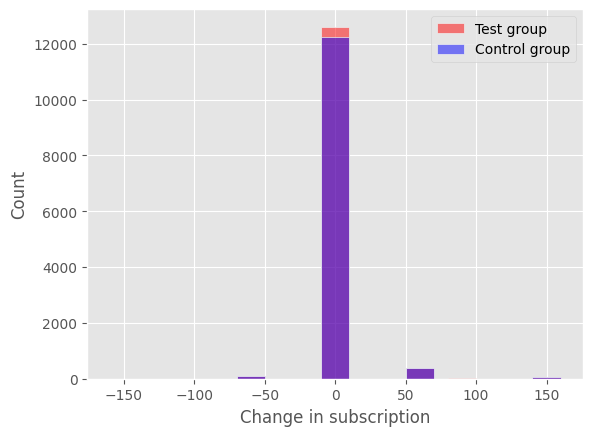

In [10]:
sns.histplot(test_subscribe, binwidth=10, alpha=0.5, discrete=True, shrink=20, label='Test group', color="red")
sns.histplot(control_subscribe, binwidth=10, alpha=0.5, discrete=True, shrink=20, label='Control group', color="blue")

plt.ylabel("Count")
plt.xlabel("Change in subscription")

plt.legend()

*Вопрос: Можно ли воспользоваться предпосылкой о нормальности распределения приростов и проверить гипотезу тестом Уэлча?*

Ответ: нет, нельзя, распределения дискретны, а не нормальны

*Вопрос: Переменная, для которой мы проводим тест имеет дискретное распределение. Можно ли здесь использовать тест Манна-Уитни? Даст ли это коректный результат?*

Ответ: Да, можно, но с оговорками.

Наиболее распространенный тест Манна-Уитни - для непрерывных распределений, которые могут отличаться лишь смещением на некоторую величину, как альтернативная гипотеза. Тогда это тест на равенство медиан.

Но также тест Манна-Уитни может быть сформулирован и для дискретных распределений более произвольного вида.

В пакете scipy, например, можно использовать method='asymtotic', который делает поправку на совпадение элементов (ties). Точный метод method='exact' не делает такой поправки, что в нашем случае очень существенно.

In [11]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(control_subscribe, test_subscribe, method="asymptotic", alternative="less")

In [12]:
print(U1, p)

84213458.0 0.7662079188290909


*Вопрос: Будет ли корректно использовать для проверки гипотезы ЦПТ и тест о равенстве средних, основанный на ней?*

Да, корректно. Наблюдений много, они независимы  - одним пользователям предоставили скидку, другим не предоставили


Правда ли, что средняя длительность подписки изменилась на $1\%$ уровне значимости? Для ответа на этот вопрос воспользуйтесь асимптотическим тестом на равенство средних против двусторонней альтернативы. Сохраните в переменную `z_obs` получившееся значение статистики, а в `pvalue` получившееся $p$-значение.

##### Вручную

In [13]:
x1 = test_subscribe
n = len(x1)

x2 = control_subscribe
m = len(x2)

z_obs = (x1.mean() - x2.mean()) / np.sqrt(x1.var(ddof=1)/n + x2.var(ddof=1)/m)

In [14]:
p_value_two_tailed = 2 * sts.norm.sf(abs(z_obs))

In [15]:
z_obs, p_value_two_tailed

(np.float64(-0.7476223219885133), np.float64(0.45468799669079174))

##### При помощи пакета statsmodel

In [16]:
from statsmodels.stats.weightstats import ztest

In [17]:
z_obs, pvalue = ztest(test_subscribe, control_subscribe, usevar='unequal')

In [18]:
print(z_obs, pvalue )

-0.7476223219884844 0.4546879966908093


In [19]:
# проверка того, что задание решено верно
assert np.abs(z_obs) < 1
assert np.abs(z_obs) > 0.7

# подобные тесты скрыты от вас


Ответ: pvalue больше 0.01, нулевая гипотеза не отвергается

Теперь попробуем проверить, что распределения одинаковы тестом Пирсона

In [20]:
frequencies = pd.merge(test_subscribe.value_counts(), control_subscribe.value_counts(), on='subscribe_difference', suffixes=("_test", "_control"), how='outer')

In [21]:
frequencies

,count_test,count_control
subscribe_difference,,
-150.0,1,NaN
-90.0,1,2.0
-60.0,94,89.0
0.0,12610,12253.0
60.0,368,375.0
90.0,8,7.0
150.0,62,65.0


In [22]:
frequencies.fillna(0, inplace=True)

In [23]:
frequencies.count_test = frequencies.count_test / frequencies.count_test.sum()
frequencies.count_control = frequencies.count_control / frequencies.count_control.sum()

In [24]:
from scipy.stats import chisquare

In [25]:
frequencies.count_test

,count_test
subscribe_difference,
-150.0,0.000076
-90.0,0.000076
-60.0,0.007152
0.0,0.959373
60.0,0.027998
90.0,0.000609
150.0,0.004717


In [26]:
statistic, pvalue = chisquare(frequencies.count_control, frequencies.count_test)

In [27]:
statistic, pvalue

(np.float64(0.00026478887530488723), np.float64(0.9999999999996133))

Таким образом, никаких значимых отличий в распределениях при помощи теста Пирсона также не обнаружено

__б)__ А теперь представим, что мы продвинутые АБ-тестеры и решили провести ААБ тест (2 контрольные группы и одну тестовую).

In [28]:
df2 = pd.read_csv('subscribers_2.csv', sep=',')
print(df2.shape)
df2.head( )

(25935, 10)


,user_id,service_id,product_name,product_duration,rn,sale_date,last_duration_days,new_duration_days,is_same,new_group
0,47233,929,subscription,1_month,1,2018-12-21,30.0,30,1,0
1,50195,929,subscription,1_month,1,2019-03-17,30.0,30,1,2
2,62594,929,subscription,1_month,1,2019-02-08,30.0,30,1,0
3,68918,929,subscription,1_month,2,2019-03-19,30.0,30,1,2
4,91900,929,subscription,3_month,1,2018-10-29,30.0,90,0,0


* `new_group` - группа теста, в которую попал пользователь. $2$ - тест, $0,1$ - контроль.

Проверим число пользователей в различных группах

In [29]:
df2.groupby('new_group').agg({'new_group':'count'})

,new_group
new_group,
0,8509
1,8595
2,8831


In [30]:
df2['subscribe_difference'] = df2['new_duration_days'] - df2['last_duration_days']

In [31]:
test = df2[df2['new_group']==2]['subscribe_difference']
control_0 = df2[df2['new_group']==0]['subscribe_difference']
control_1 = df2[df2['new_group']==1]['subscribe_difference']

Проверьте гипотезу о том, что в каждой из контрольных групп среднее совпадает с тестовой на уровне значимости $1\%$. Получившиеся $p$-значения запишите в переменные `pval_1` и `pval_2`. Сделайте корректировку методом Холма. Запишите количество отвергнутых гипотез в переменную `hyp_cnt`.

In [32]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

_, pval_1 = ztest(test, control_0, usevar='unequal')
_, pval_2 = ztest(test, control_1, usevar='unequal')

# your code here


In [33]:
print(pval_1, pval_2)

0.4466393294905775 0.33223046480891105


Гипотеза H0 на уровне значимости 0.01 не отвергается

In [34]:
from statsmodels.stats.multitest import multipletests

In [35]:
_, pvals_corrected, _, _ =multipletests( [pval_1, pval_2], method="holm" )

In [36]:
pvals_corrected

array([0.66446093, 0.66446093])

In [37]:
# проверка того, что задание решено верно
assert pval_1 < 0.5
assert pval_1 > 0.4
assert pval_2 > 0.3
assert pval_2 < 0.4

# подобные тесты скрыты от вас

*Вопрос: Какие выводы можно сделать из этого теста?  Валиден ли такой тест?  Если нет, то в чем может быть проблема? Если тут вообще смысл делать поправку Холма?*

Ответ: Можно сделать выводы о том, что среднее не меняется. Тест валиден, т.к. содержит большое количество наблюдений и применим z-test  

Смысла применять поправку Холма особого нет, так как она призвана избежать ошибки 1 рода и увеличивает pvalue соответствующим образом. Но у нас и так не отвергалась нулевая гипотеза, так что я полагаю в этом нет смысла